# Previsão com Modelos de Suavização

### - Moving Average
### - Exponencial Simples
### - Exponencial Duplo
### - Exponencial Triplo

In [32]:
import pandas as pd
from pandas import Grouper, DataFrame
from pandas.plotting import autocorrelation_plot

from typing import Tuple, List, Callable, Dict

import numpy as np
import os
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

import inspect
import warnings

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

TEST_SPLIT_SIZE = 10

MEAN_SQUARED_METRIC = "mean_squeared"
MEAN_ABSOLUTE_METRIC = "mean_absolute"
R2_METRIC = "r2"

## Funções

In [4]:
#Separa os dados em treino, teste (resultdado) e teste_dataset (um teste 
def split_train_test_window_dataset(full_dataset: np.ndarray, test_percentual_size: int, window_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    dataset_size: int = full_dataset.shape[0]
    cut_pos: int = round(dataset_size - (dataset_size * (test_percentual_size /100)))
    test_dataset_size: int = dataset_size - cut_pos
    
    X_test: np.ndarray = full_dataset[window_size : cut_pos]
    y_test: np.ndarray = full_dataset[cut_pos:]
    
    train_dataset_list = [full_dataset[ind : ind + window_size] for ind in range (cut_pos - window_size)]
    X_train = np.array(train_dataset_list)
    
    test_dataset_list = [full_dataset[cut_pos + ind - window_size:cut_pos + ind] for ind in range (test_dataset_size)]
    y_train = np.array(test_dataset_list)
    
    return X_train, X_test, y_train, y_test

In [5]:
def get_predictions_performance(y_pred: np.ndarray, y_true: np.ndarray, metric: str):
    if metric == MEAN_ABSOLUTE_METRIC:
        return mean_absolute_error(y_true, y_pred)
    elif metric == MEAN_SQUARED_METRIC:
        return mean_squared_error(y_true, y_pred, squared=True)
    elif metric == R2_METRIC:
        return r2_score(y_true, y_pred)
    else:
        raise ValueError(f"Métrica informada é inválida {metric}")
        

In [6]:
# Os parametros para busca tem uma chave (nome do parametro) e uma lista que contem o valor mínimo e máximo
#def grid_search(observations: np.ndarray, test_size: int, pred_function: Callable, function_params: Dict[str, List[int]]) -> Dict[str,int]:
 #   chaves: str = function_params.keys()
    
  #  print(list(inspect.signature(pred_function).parameters.keys()))
    
def get_best_window_size(observations: np.ndarray, 
                         test_split_size: int,
                         pred_function: Callable, 
                         min_size: int = 2, max_size: int = 12,
                         metric: str = R2_METRIC) -> Tuple[int,float]:
    
    window_dict: Dict[int, float] = {}
    
    for w_size in range(min_size, max_size+1):
        predicted_list: List[float] = []
        _, _, y_train, y_test = split_train_test_window_dataset(observations, test_split_size, w_size)
        
        for p in range (len(y_train)):
            predicted_list.append(pred_function(y_train[p]))
        predicted: np.ndarray = np.array(predicted_list)
        value_metric = get_predictions_performance(predicted, y_test, metric)
        window_dict[w_size] = value_metric
    
    print(window_dict)
    best_w_size = 0
    if metric == R2_METRIC:
        best_value = -10000000
    elif metric == MEAN_ABSOLUTE_METRIC or metric == MEAN_SQUARED_METRIC:
        bet_value = 10000000
    else:
        raise ValueError(f"Métrica informada é inválida {metric}")
    
    for key in window_dict.keys():
        valor_atual: float = window_dict[key];
        if metric == R2_METRIC:
            if (valor_atual > best_value):
                best_value = valor_atual
                best_w_size = key
        elif metric == MEAN_ABSOLUTE_METRIC or metric == MEAN_SQUARED_METRIC:
            if (valor_atual < best_value):
                best_value = valor_atual
                best_w_size = key        
        
    return best_w_size, best_value
        

In [7]:
# Retorna X_test, y_pred, y_test respectivamente
def execute_prevision(pred_function: Callable, window_size:int, observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    X_train, X_test, y_train, y_test = split_train_test_window_dataset(observations, TEST_SPLIT_SIZE, window_size)
    prediction_list:List = []
    for t_index in range(len(y_train)):
        valor_previsto = pred_function(y_train[t_index])
        prediction_list.append(valor_previsto)
    prediction = np.array(prediction_list)
    
    return X_test, prediction, y_test

## Carrega Datasets

In [3]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

#retirando tendencia com a série de diferença
diff_desembolso = np.diff(desembolso)

---

## Média Movel

In [8]:
def predict_by_moving_average(observations):
    return np.sum(observations) / observations.shape[0]

In [9]:
best_window_ma, best_metric_value_ma = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_moving_average, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.05416470040567223, 3: -0.17336320511767545, 4: -0.26866956184909463, 5: -0.13697891016732333, 6: -0.08469552544540937, 7: -0.12290814081115586, 8: -0.15645568019380707, 9: -0.10167581071817988, 10: -0.03754424518378552, 11: 0.04000805886688974, 12: 0.07216053724695337}


In [10]:
X_test, ma_prediction, y_true = execute_prevision(predict_by_moving_average, best_window_ma, desembolso)

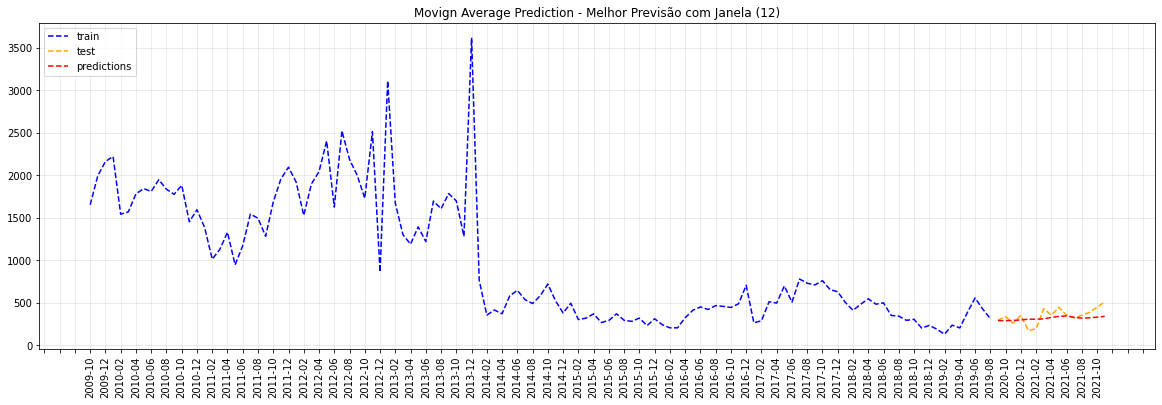

In [11]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(ma_prediction):], ma_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Movign Average Prediction - Melhor Previsão com Janela ({best_window_ma})")
plt.grid(alpha=0.3);

In [12]:
ma_mse = mean_squared_error(y_true, ma_prediction, squared=True)
ma_mae = mean_absolute_error(y_true, ma_prediction)
ma_r2 = r2_score(y_true, ma_prediction)
print(f'Mean Squared Error: {ma_mse} ')
print(f'Mean Absolute Error: {ma_mae}')
print(f'R2 Score: {ma_r2}')

Mean Squared Error: 7444.364736799774 
Mean Absolute Error: 69.25498146333332
R2 Score: 0.07216053724695337


#### Tentativa com a série estacionária da diferença

In [14]:
best_window_ma, best_metric_value_ma = get_best_window_size(diff_desembolso , TEST_SPLIT_SIZE, predict_by_moving_average, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.7930312528144821, 3: -0.43786277271428187, 4: -0.4882512983702496, 5: -0.21382301590509356, 6: -0.16229024272381976, 7: -0.1851161343035086, 8: -0.2641799894344823, 9: -0.13027479014485577, 10: -0.10508965937556103, 11: -0.0785638621905862, 12: -0.017840945796952612}


> Resultados piores

---

## Exponencial
1. Suavização exponencial única - sem tendência ou sazonalidade
2. Suavização exponencial dupla - captura tendência
3. Suavização Exponencial Tripla - captura tendência e sazonalidade

### Exponencial Único

In [22]:
def predict_by_simple_exponential(observations):
    single_exp_model = SimpleExpSmoothing(observations).fit(optimized=True)
    single_preds = single_exp_model.forecast(1)
    return single_preds[0]

In [14]:
best_window_exp_1, best_metric_value_exp_1 = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_simple_exponential, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.0541647631535207, 3: 0.10391605340945498, 4: 0.0037526826310525507, 5: 0.10135104511820914, 6: -0.0634896353328076, 7: -0.06810404699940631, 8: -0.2476098399362796, 9: -0.35014523501591155, 10: -0.3095990004686504, 11: -0.15068977836825437, 12: -0.32082733382986195}


In [15]:
X_test, exp_1_prediction, y_true = execute_prevision(predict_by_simple_exponential, best_window_exp_1, desembolso)

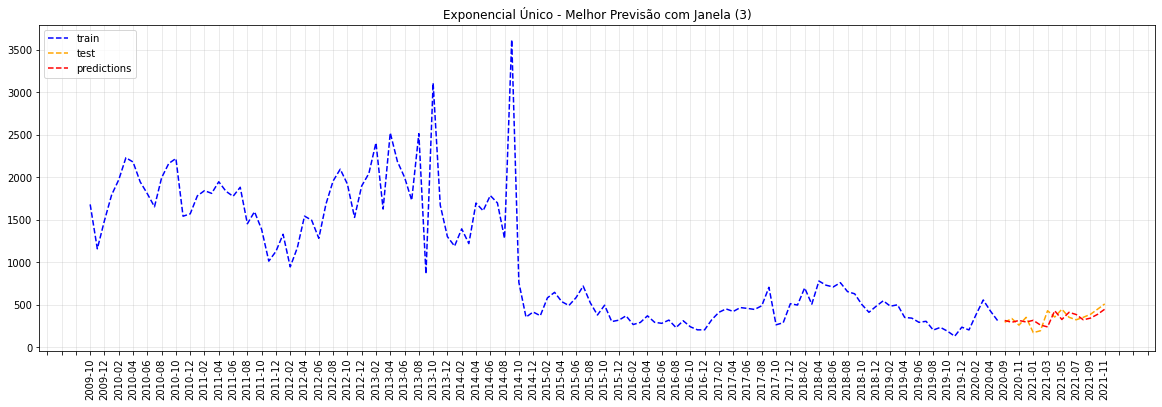

In [16]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(exp_1_prediction):], exp_1_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Único - Melhor Previsão com Janela ({best_window_exp_1})")
plt.grid(alpha=0.3);

In [17]:
single_exp_mse = mean_squared_error(y_true, exp_1_prediction, squared=True)
single_exp_mae = mean_absolute_error(y_true, exp_1_prediction)
single_exp_r2 = r2_score(y_true, exp_1_prediction)
print(f'Mean Squared Error: {single_exp_mse} ')
print(f'Mean Absolute Error: {single_exp_mae}')
print(f'R2 Score: {single_exp_r2}')

Mean Squared Error: 7189.5796643718695 
Mean Absolute Error: 72.59387713427483
R2 Score: 0.10391605340945498


#### Tentativa com a série estacionária da diferença

In [23]:
best_window_exp_1, best_metric_value_exp_1 = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_simple_exponential, min_size=2, max_size=12, metric=R2_METRIC)

{2: -0.7930317309584913, 3: -1.0109158546673713, 4: -0.5839550967301814, 5: -0.2866203453153684, 6: -0.1909697869764051, 7: -0.20764366003696355, 8: -0.25468631944514386, 9: -0.14528543002456384, 10: -0.13257563730871302, 11: -0.08336435224660876, 12: -0.10426915071116771}


> Novamente resultados piores

---

### Exponencial Duplo

In [26]:
def predict_by_double_exponential(observations):
    double_exp_model = Holt(observations).fit(optimized=True)
    double_preds = double_exp_model.forecast(1)
    return double_preds[0]

In [21]:
best_window_double_exp, best_metric_value_double_exp = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_double_exponential, min_size=2, max_size=12, metric=R2_METRIC)

{2: -2.1856652773541665, 3: -0.9969305390657035, 4: -1.006676993640482, 5: -0.6968141826466034, 6: -0.4086520019360729, 7: -0.5154140106597755, 8: -0.5018932118054995, 9: -0.5236774368073369, 10: -0.4776309197250168, 11: -0.19820010128535248, 12: -0.44908267521719725}


In [22]:
X_test, double_exp_prediction, y_true = execute_prevision(predict_by_double_exponential, best_window_double_exp, desembolso)

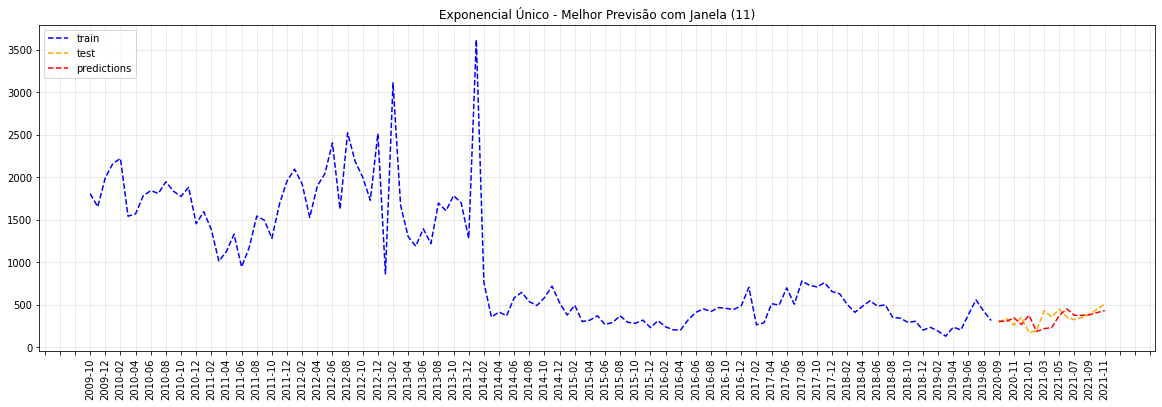

In [24]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(double_exp_prediction):], double_exp_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Duplo - Melhor Previsão com Janela ({best_window_double_exp})")
plt.grid(alpha=0.3);

In [25]:
double_exp_mse = mean_squared_error(y_true, double_exp_prediction, squared=True)
double_exp_mae = mean_absolute_error(y_true, double_exp_prediction)
double_exp_r2 = r2_score(y_true, double_exp_prediction)
print(f'Mean Squared Error: {double_exp_mse} ')
print(f'Mean Absolute Error: {double_exp_mae}')
print(f'R2 Score: {double_exp_r2}')

Mean Squared Error: 9613.558098910797 
Mean Absolute Error: 75.97119305607431
R2 Score: -0.19820010128535248


#### Tentativa com a série estacinária da diferença

In [27]:
best_window_double_exp, best_metric_value_double_exp = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_double_exponential, min_size=2, max_size=12, metric=R2_METRIC)

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


{2: -8.089364072984967, 3: -3.8387191703359607, 4: -2.0343454534449963, 5: -2.479337016230244, 6: -1.494938014699244, 7: -1.0012882593969645, 8: -0.6440337725138978, 9: -0.8516745544632913, 10: -1.7630685212154242, 11: -6.563162199073495, 12: -1.513257219909077}


---

### Exponencial Triplo

In [29]:
def predict_by_triple_exponential(observations):
    triple_exp_model = ExponentialSmoothing(observations,
                              trend="multiplicative",
                              seasonal="multiplicative",
                              seasonal_periods=12).fit(optimized=True)
    triple_preds = triple_exp_model.forecast(1)
    return triple_preds[0]

In [51]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    best_window_triple_exp, best_metric_value_triple_exp = get_best_window_size(desembolso, TEST_SPLIT_SIZE, predict_by_triple_exponential, min_size=24, max_size=48, metric=R2_METRIC)

{24: -1.3445514495554582, 25: -0.849748297188379, 26: -0.6487091972967924, 27: -0.16857279252942026, 28: -0.08329346502681911, 29: -0.10013086817336925, 30: -0.3496787430148016, 31: -1.2546809311204883, 32: -0.8963923748939027, 33: -1.2361025303095294, 34: -0.8605067452565156, 35: -0.6079709417864694, 36: -0.13608678110394123, 37: 0.368669025140686, 38: 0.44334037347245714, 39: 0.3038034090136099, 40: 0.38685555083316325, 41: 0.2459055852270654, 42: 0.3647357102646931, 43: 0.2783089993889273, 44: 0.2484433918342116, 45: 0.25826668857703916, 46: 0.2356419311641884, 47: 0.2649876235789911, 48: -0.0363787222905696}


In [52]:
X_test, triple_exp_prediction, y_true = execute_prevision(predict_by_triple_exponential, best_window_triple_exp, desembolso)

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


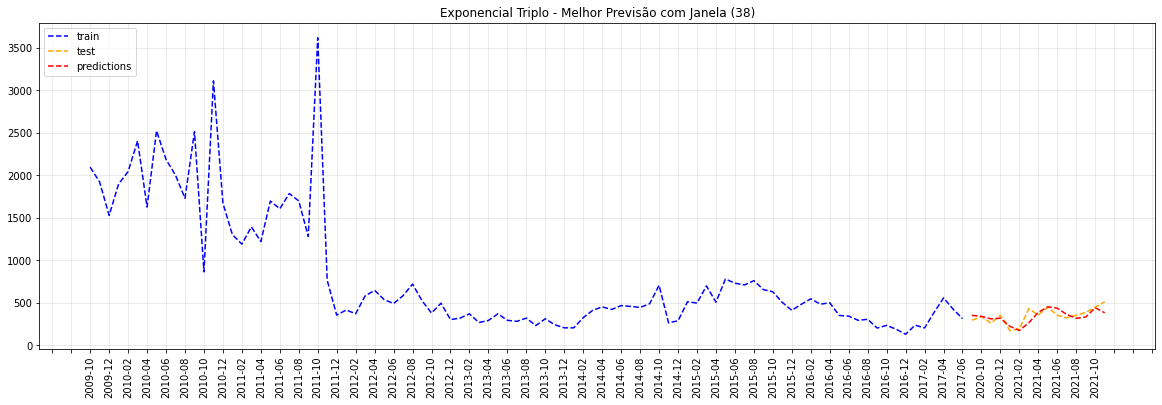

In [53]:
plt.figure(figsize=(20,6))
plt.xticks(rotation='vertical')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.plot(desembolso_time[:len(X_test)], X_test, 'b--', label="train")
plt.plot(desembolso_time[-len(y_true):], y_true, color='orange', linestyle="--", label="test")
plt.plot(desembolso_time[-len(triple_exp_prediction):], triple_exp_prediction, 'r--', label="predictions")
plt.legend(loc='upper left')
plt.title(f"Exponencial Triplo - Melhor Previsão com Janela ({best_window_triple_exp})")
plt.grid(alpha=0.3);

In [54]:
triple_exp_mse = mean_squared_error(y_true, triple_exp_prediction, squared=True)
triple_exp_mae = mean_absolute_error(y_true, triple_exp_prediction)
triple_exp_r2 = r2_score(y_true, triple_exp_prediction)
print(f'Mean Squared Error: {triple_exp_mse} ')
print(f'Mean Absolute Error: {triple_exp_mae}')
print(f'R2 Score: {triple_exp_r2}')

Mean Squared Error: 4466.265405252257 
Mean Absolute Error: 50.8531873038726
R2 Score: 0.44334037347245714


#### Tentativa com a série estacionária da Diferença não foi possível porque exigia valores positivos

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    best_window_triple_exp, best_metric_value_triple_exp = get_best_window_size(diff_desembolso, TEST_SPLIT_SIZE, predict_by_triple_exponential, min_size=24, max_size=48, metric=R2_METRIC)

ValueError: endog must be strictly positive when usingmultiplicative trend or seasonal components.

---
## AUTOREGRESSIVE MODELS